In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

/home/kalpesh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kalpesh/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/kalpesh/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=Futur

In [2]:
df = pd.read_csv('Data/train.csv')
df = df.reindex(np.random.permutation(df.index))
df['tweet']=df['tweet'].astype(str)

In [3]:
df.head()

,tweet_id,tweet,sentiment
4559,4043,"Msft panel on touch interfaces shows a bunch of tablets, but no iPad #sxsw #DontBeHatin",2
770,8864,#SXSW crowd in Austin swarms for iPad 2 launch {link} via @mention - sadly I wasn't one of them :-(,2
7160,1183,"of course they are, ha RT @mention @mention Apple opening temporary store in Austin for #SXSW &amp; iPad 2 launch {link}",1
6015,6022,"RT @mention Hm? Do we need another 1? RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",0
5288,2870,"As the geeks leave Austin and the music people hit town, the look and feel becomes more unique, less apple branded. #SXSW",1


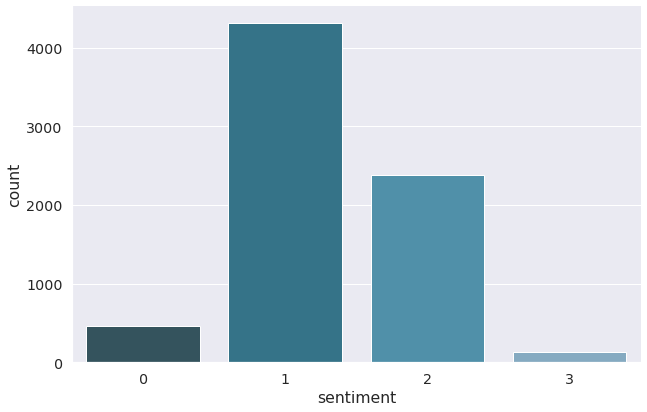

In [4]:
sns.factorplot(x="sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [5]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.tweet)
df_eda['sentiment'] = df.sentiment

In [6]:
df_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment
4559,15,0,2,0,0,0,0,2
770,19,1,1,1,0,0,0,2
7160,21,2,1,2,0,0,0,1
6015,23,2,1,2,2,0,0,0
5288,22,0,1,1,0,0,0,1


In [7]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0          456.0   19.500000  5.405736  6.0  16.0  20.0  24.0  32.0
1          4311.0  18.041058  5.229040  1.0  14.0  18.0  22.0  41.0
2          2382.0  18.863980  5.289912  4.0  15.0  19.0  23.0  35.0
3          125.0   18.152000  5.296158  8.0  14.0  18.0  22.0  30.0


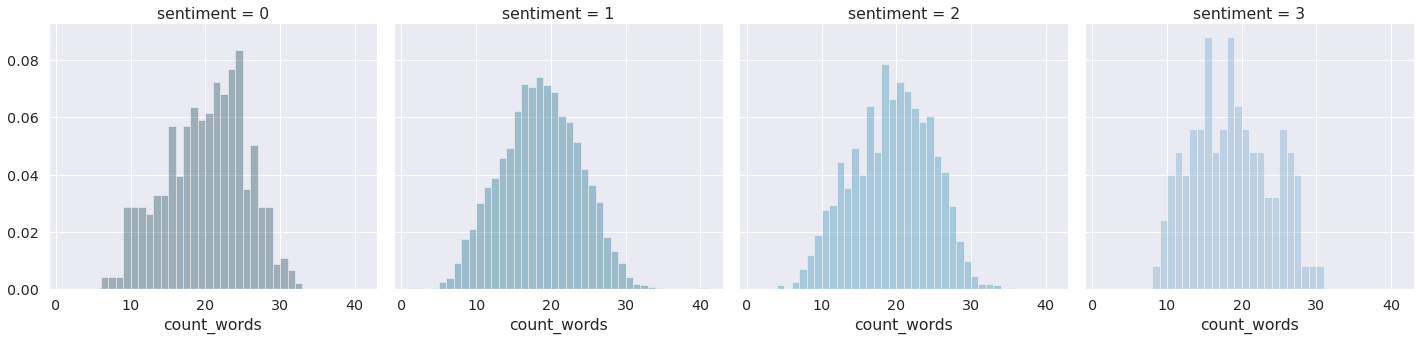

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.552632  0.739374  0.0  0.0  0.0  1.0  4.0
1          4311.0  0.850151  0.976427  0.0  0.0  1.0  1.0  8.0
2          2382.0  0.740134  0.838025  0.0  0.0  1.0  1.0  5.0
3          125.0   0.640000  0.962188  0.0  0.0  0.0  1.0  5.0


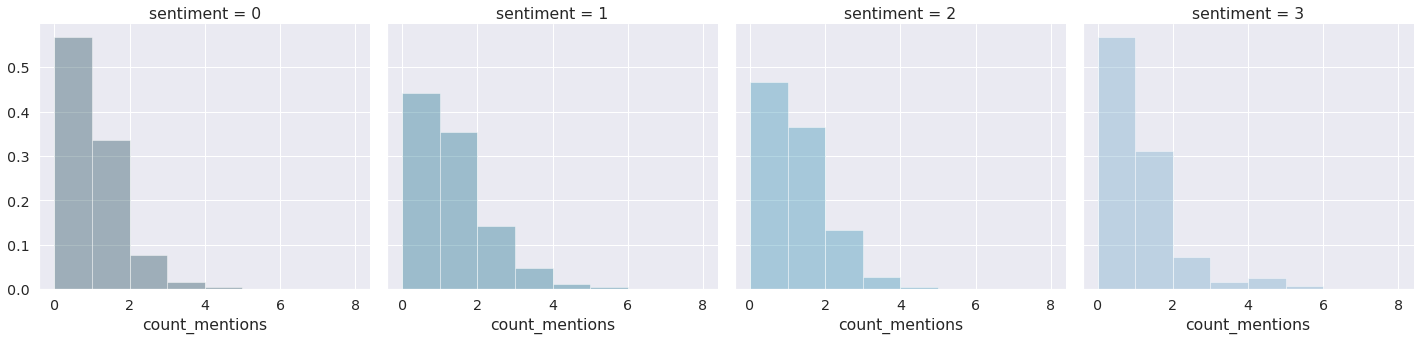

Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   1.605263  0.839868  1.0  1.0  1.0  2.0  6.0 
1          4311.0  1.792160  1.180642  0.0  1.0  1.0  2.0  12.0
2          2382.0  1.683039  0.952835  0.0  1.0  1.0  2.0  7.0 
3          125.0   1.600000  0.950382  1.0  1.0  1.0  2.0  5.0 


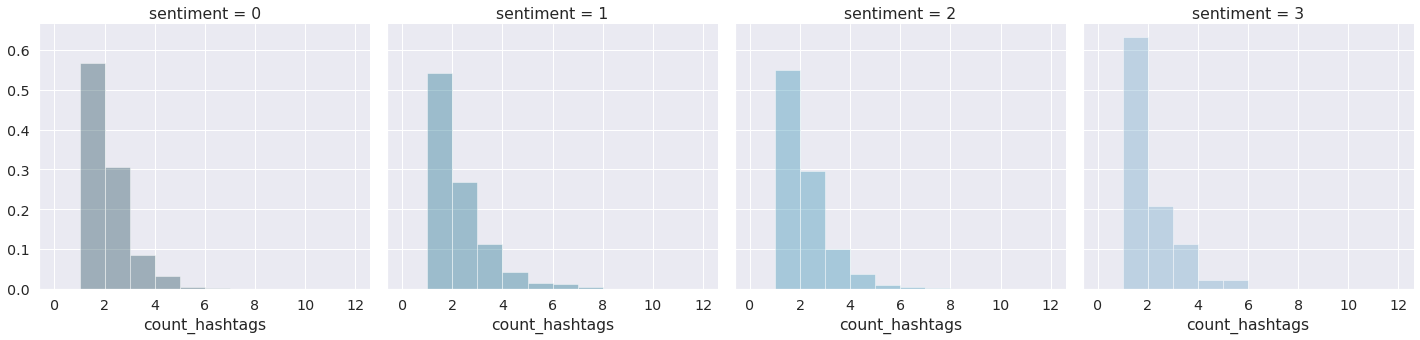

Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.901316  1.199413  0.0  0.0  1.0  1.0  18.0
1          4311.0  1.109951  1.060565  0.0  0.0  1.0  2.0  17.0
2          2382.0  1.033165  0.963940  0.0  0.0  1.0  2.0  6.0 
3          125.0   0.976000  0.919888  0.0  0.0  1.0  1.0  4.0 


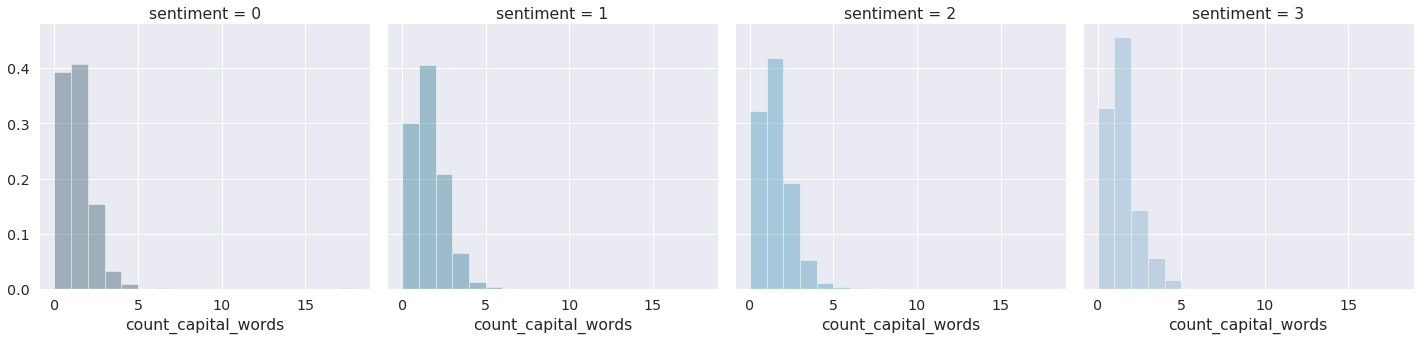

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.361842  0.819134  0.0  0.0  0.0  0.0  8.0 
1          4311.0  0.406170  0.767646  0.0  0.0  0.0  1.0  11.0
2          2382.0  0.548699  0.903084  0.0  0.0  0.0  1.0  9.0 
3          125.0   0.424000  0.825638  0.0  0.0  0.0  1.0  3.0 


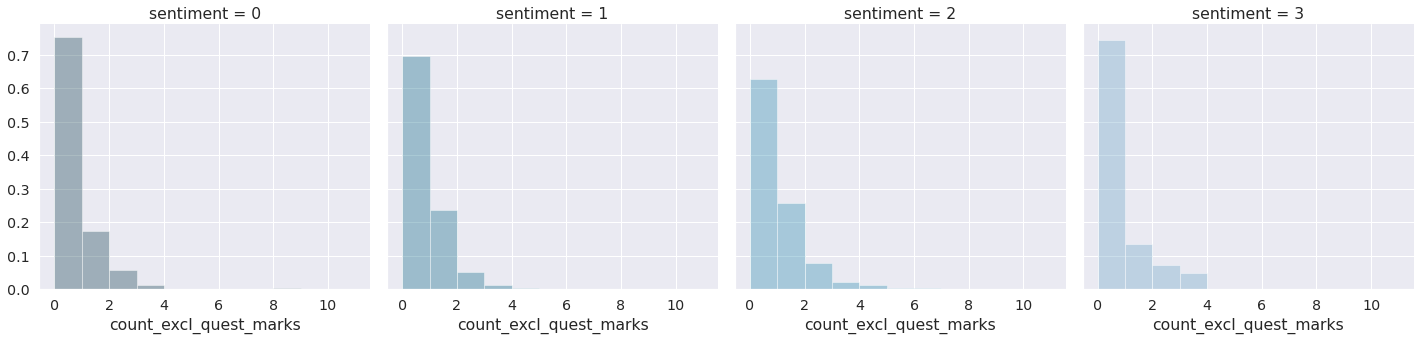

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4311.0  0.001624  0.040268  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.004618  0.067813  0.0  0.0  0.0  0.0  1.0
3          125.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


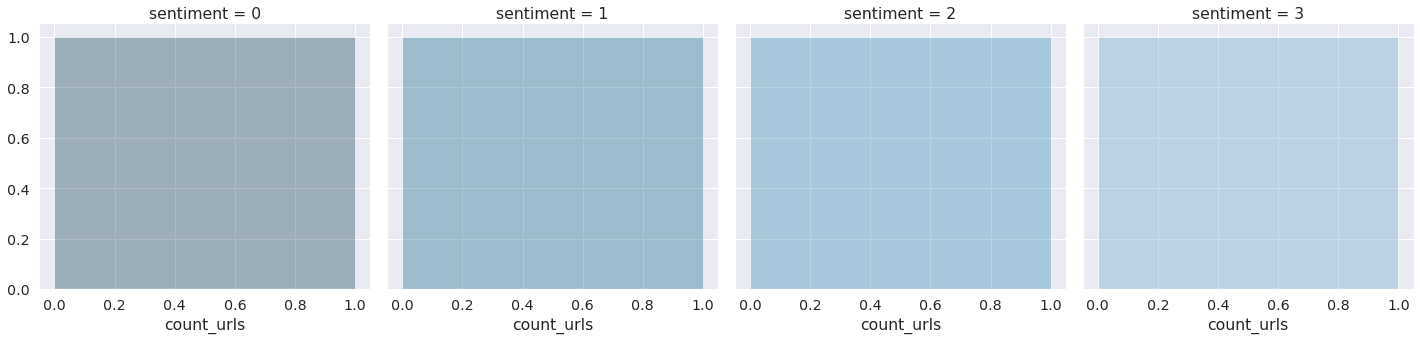

Descriptive stats for count_emojis
----------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4311.0  0.001624  0.040268  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.001259  0.035474  0.0  0.0  0.0  0.0  1.0
3          125.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


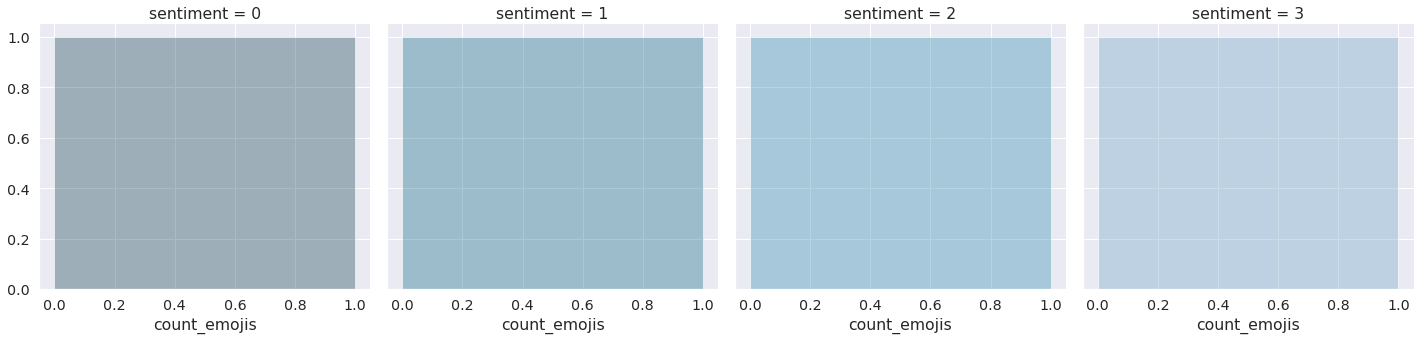

Descriptive stats for sentiment
-------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0          456.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
1          4311.0  1.0   0.0  1.0  1.0  1.0  1.0  1.0
2          2382.0  2.0   0.0  2.0  2.0  2.0  2.0  2.0
3          125.0   3.0   0.0  3.0  3.0  3.0  3.0  3.0


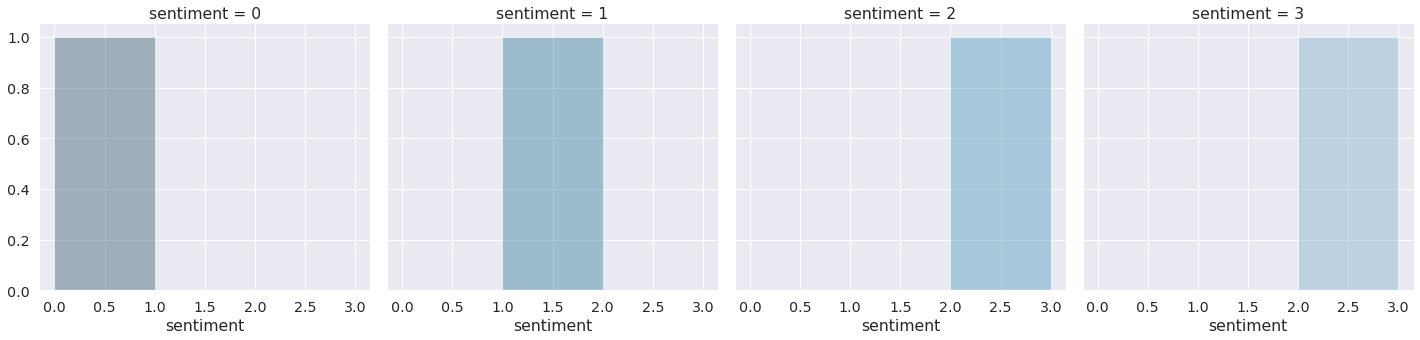

In [8]:
for i in df_eda.columns:
    show_dist(df_eda,i)

In [9]:
class CleanText(BaseEstimator, TransformerMixin):

    # Function for expanding contractions
    def expand_contractions(self, text):
        # Dictionary of English Contractions
        contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                             "can't": "cannot","can't've": "cannot have",
                             "'cause": "because","could've": "could have","couldn't": "could not",
                             "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                             "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                             "hasn't": "has not","haven't": "have not","he'd": "he would",
                             "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                             "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                             "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                             "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                             "it'd": "it would","it'd've": "it would have","it'll": "it will",
                             "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                             "mayn't": "may not","might've": "might have","mightn't": "might not", 
                             "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                             "mustn't've": "must not have", "needn't": "need not",
                             "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                             "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                             "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                             "she'll": "she will", "she'll've": "she will have","should've": "should have",
                             "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                             "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                             "there'd've": "there would have", "they'd": "they would",
                             "they'd've": "they would have","they'll": "they will",
                             "they'll've": "they will have", "they're": "they are","they've": "they have",
                             "to've": "to have","wasn't": "was not","we'd": "we would",
                             "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                             "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                             "what'll've": "what will have","what're": "what are", "what've": "what have",
                             "when've": "when have","where'd": "where did", "where've": "where have",
                             "who'll": "who will","who'll've": "who will have","who've": "who have",
                             "why've": "why have","will've": "will have","won't": "will not",
                             "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                             "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                             "y'all'd've": "you all would have","y'all're": "you all are",
                             "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                             "you'll": "you will","you'll've": "you will have", "you're": "you are",
                             "you've": "you have","would b":"would be"}
        # Regular expression for finding contractions
        contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)
   
    def remove_mentions(self, input_text):
        input_text=text = re.sub(r'[\w]*sxsw[\w]*', '', input_text, flags=re.I)  #Removing sxsw hashtag
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words if word not in ['link','rt','sxsw','amp','quot','http','html']]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.expand_contractions).apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [10]:
ct = CleanText()
sr_clean = ct.fit_transform(df.tweet)
sr_clean.sample(5)

1399    no android version download iphon reserv space                               
6026    checkin crowley googl social space not know go look like                     
4613    awesom present digit magazin touchingstori gsdm                              
2338    great new support web font googl                                             
2921    googl not view final end rather tool point user sourc make decis marissagoogl
Name: tweet, dtype: object

In [11]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

1 records have no words left after text cleaning


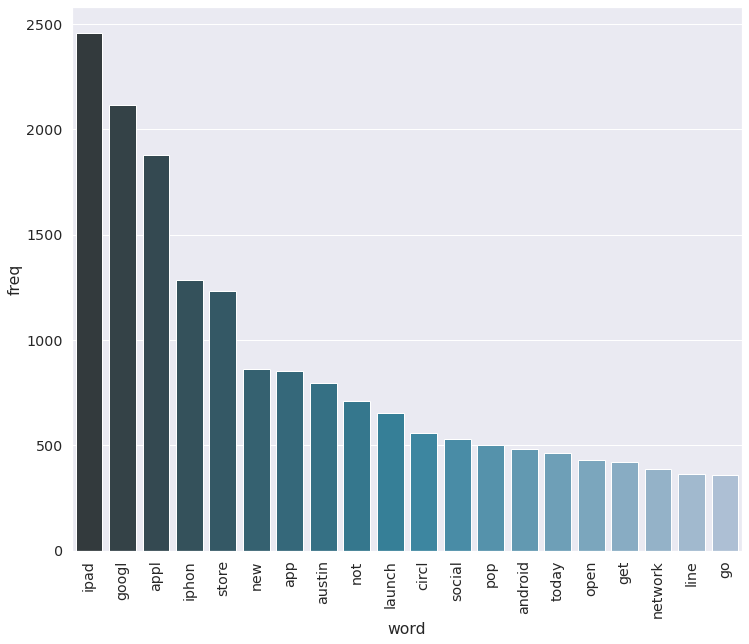

In [12]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.xticks(rotation=90)
plt.show();

In [13]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'sentiment',
 'clean_text']

In [14]:
df_model.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,sentiment,clean_text
4559,15,0,2,0,0,0,0,2,msft panel touch interfac show bunch tablet no ipad dontbehatin
770,19,1,1,1,0,0,0,2,crowd austin swarm ipad launch via sadli not one
7160,21,2,1,2,0,0,0,1,cours ha appl open temporari store austin ipad launch
6015,23,2,1,2,2,0,0,0,hm need anoth googl launch major new social network call circl possibl today
5288,22,0,1,1,0,0,0,1,geek leav austin music peopl hit town look feel becom uniqu less appl brand


In [15]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model.drop('sentiment', axis=1), 
    df_model.sentiment, 
    test_size=0.2, 
    random_state=0
)

In [17]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    print("\nConfusion Matrix Test Data")
    print(confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [18]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [19]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [20]:
countvect = CountVectorizer()

In [21]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.7s finished


done in 23.123s

Best CV score: 0.664
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.663


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.74      0.16      0.26        90
           1       0.69      0.82      0.75       857
           2       0.59      0.51      0.55       480
           3       0.00      0.00      0.00        28

    accuracy                           0.66      1455
   macro avg       0.50      0.37      0.39      1455
weighted avg       0.65      0.66      0.64      1455


Confusion Matrix Test Data
[[ 14  54  22   0]
 [  5 707 145   0]
 [  0 236 244   0]
 [  0  25   3   0]]


In [22]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.8min finished


done in 174.074s

Best CV score: 0.675
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.678


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.65      0.19      0.29        90
           1       0.71      0.83      0.77       857
           2       0.61      0.53      0.57       480
           3       0.00      0.00      0.00        28

    accuracy                           0.68      1455
   macro avg       0.49      0.39      0.41      1455
weighted avg       0.66      0.68      0.66      1455


Confusion Matrix Test Data
[[ 17  51  22   0]
 [  6 715 136   0]
 [  2 223 255   0]
 [  1  20   7   0]]


In [23]:
tfidfvect = TfidfVectorizer()

In [24]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.0s finished


done in 21.704s

Best CV score: 0.652
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.664


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.67      0.07      0.12        90
           1       0.68      0.88      0.77       857
           2       0.62      0.43      0.51       480
           3       0.00      0.00      0.00        28

    accuracy                           0.66      1455
   macro avg       0.49      0.34      0.35      1455
weighted avg       0.64      0.66      0.63      1455


Confusion Matrix Test Data
[[  6  58  26   0]
 [  3 753 101   0]
 [  0 273 207   0]
 [  0  26   2   0]]


In [25]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.5min finished


done in 151.992s

Best CV score: 0.646
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.641


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.66      0.88      0.75       857
           2       0.58      0.36      0.45       480
           3       0.00      0.00      0.00        28

    accuracy                           0.64      1455
   macro avg       0.31      0.31      0.30      1455
weighted avg       0.58      0.64      0.59      1455


Confusion Matrix Test Data
[[  0  68  22   0]
 [  0 758  99   0]
 [  0 305 175   0]
 [  0  23   5   0]]


In [26]:
SIZE = 25

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train.clean_text_wordlist
                 , min_count=1
                 , size=SIZE
                 , window=3
                 , workers=4)

In [27]:
model.most_similar('plane', topn=3)

[('wish', 0.9959375262260437),
 ('god', 0.9955309629440308),
 ('sure', 0.9953778982162476)]

In [28]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [29]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [30]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [31]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished


done in 3.308s

Best CV score: 0.593
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
Test score with best_estimator_: 0.587


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.60      0.93      0.73       857
           2       0.44      0.13      0.20       480
           3       0.00      0.00      0.00        28

    accuracy                           0.59      1455
   macro avg       0.26      0.26      0.23      1455
weighted avg       0.50      0.59      0.50      1455


Confusion Matrix Test Data
[[  0  77  13   0]
 [  0 793  64   0]
 [  0 419  61   0]
 [  0  26   2   0]]


In [32]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=0.5, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('sentiment', axis=1), df_model.sentiment)

# on test data

In [33]:
data=pd.read_csv('Data/test.csv')
data['tweet']=data['tweet'].astype(str)

In [34]:
df_counts_pos = tc.transform(data.tweet)
df_clean_pos = ct.transform(data.tweet)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

pred=best_model.predict(df_model_pos).tolist()

In [35]:
pred

[1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,


In [36]:
output=pd.concat([data['tweet_id'],pd.DataFrame(pred,columns=['sentiment'])],axis=1)

In [37]:
output

,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2
...,...,...
1814,1550,2
1815,1933,1
1816,9052,2
1817,4219,2


In [38]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_id   1819 non-null   int64
 1   sentiment  1819 non-null   int64
dtypes: int64(2)
memory usage: 28.5 KB


In [39]:
output.to_csv('Data/submission_file_v2.csv',index=False)

In [2]:
a=[[ 17 , 51 , 22 ,  0],
 [  6 ,715, 136  , 0],
 [  2 ,223 ,255 ,  0],
 [  1 , 20 ,  7  , 0]]

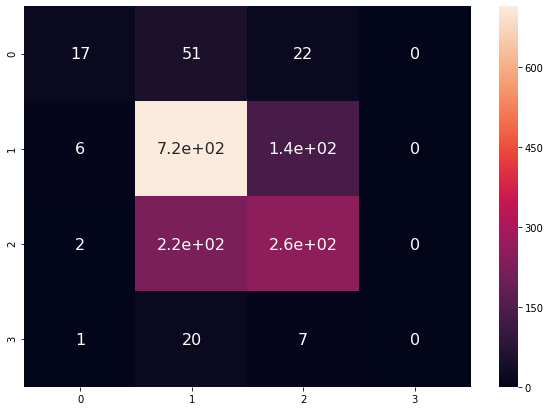

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(a, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})

In [13]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

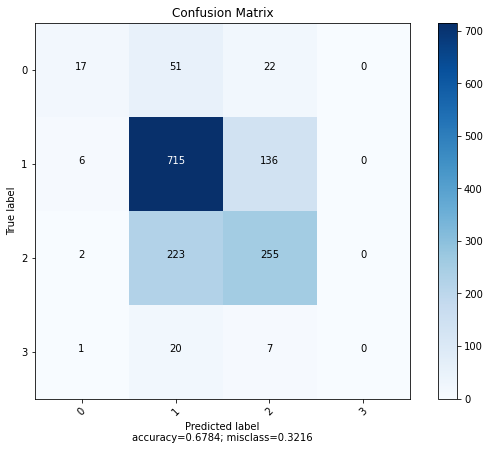

In [15]:
plot_confusion_matrix(cm           = np.array([[ 17 , 51 , 22 ,  0], [  6 ,715, 136  , 0], [  2 ,223 ,255 ,  0], [  1 , 20 ,  7  , 0]]), 
                      normalize    = False,
                      target_names = ['0','1','2','3'],
                      title        = "Confusion Matrix")